# 17.9.1-17.10

# Setup

In [31]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "autoencoders"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


A couple utility functions to plot grayscale 28x28 image:

In [32]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

Let's use MNIST:

In [33]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

# GANの復習

<img src="img/GAN.jpg" alt="GAN">

<img src="img/GAN_formula.jpg" alt="GAN_formula">

# 17.9.1 GANの訓練の難しさ

↓解説動画

https://www.youtube.com/watch?v=Ky4CXsufEvE&list=PLbtqZvaoOVPB2WCoUt9VCsl7BQHRdhb8m&index=4

https://www.youtube.com/watch?v=bpPtudXKF8c&list=PLbtqZvaoOVPB2WCoUt9VCsl7BQHRdhb8m&index=5

### 主なGANの難しさは大きく4つ

・生成された画像の評価：画像の本物らしさを客観的に判断できない(人間の主観的なものが評価になりやすい)

・勾配消失問題：学習初期にDが高性能になりすぎて(識別でほどんど0になって)、だますようにGを学習することが困難

・学習の不安定さ：そもそもmin-max型の最適化は収束が難しい。勾配法では目的関数が滑らかであることが望ましい。また、ハイパーパラメータにも敏感で学習が安定しにくい。

・モード崩壊：潜在変数を無視して1つあついは少数の全く同じデータを生成し続ける

### モード崩壊の原因

(1) 何かの拍子にDをめっちゃだませるfakeデータをGが生成

(2) めっちゃだませるので、潜在変数を無視して同じfakeデータばかりを生成し始める

(3)同じデータばかり来るので、Dは単純にそのデータをfakeと考えるようになる

(4)Dをだますようにちょっと変えたfakeデータをGが生成するようになる　→　(3)に戻る

### 改善方法

<img src = "img/GAN_improving_approach.jpg" alt="GAN_improving_approach">

<img src = "img/GAN_improving_approach2.jpg" alt="GAN_improving_approach2">

・ミニバッチ判別(モード崩壊の解消)

：バッチ内の画像の類似度を測定し、この情報を判別器に与えて、判別器が多様性の乏しい偽画像のバッチを簡単にはねつけられるようにする。

・WGAN：識別の代わりに、Realデータとfakeデータの分布缶のWasserstein計量を測って最小化する手法

Wasserstein計量は、分布を砂場として見たときに、2つの砂山の間の最小輸送コストに相当する。

↓解説サイト

https://qiita.com/triwave33/items/5c95db572b0e4d0df4f0

# 17.9.2 深層畳み込みGAN

↓解説サイト

https://data-analytics.fun/2021/11/19/understanding-dcgan/

訓練が不安定になるため難しい課題であったが、アーキテクチャとハイパーパラメータの最適化により実現

主要な指針は以下の通り

・プーリング層を、判別器ではストライドつきの畳み込み層に、生成器では転置畳み込み層に置き換える。

・生成器の出力層と判別器の入力層を除き、生成器と判別器の両方でバッチ正則化を使う。

・生成器では、出力層を除くすべての層でRELU活性化関数を使う。出力層ではtanh関数を使う。

・判別器では、全ての層でleaky ReLU活性化関数を使う。

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [35]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [36]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [37]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [38]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [39]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Epoch 1/50


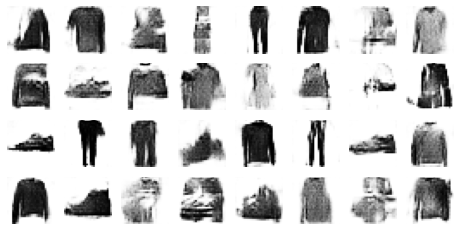

Epoch 2/50


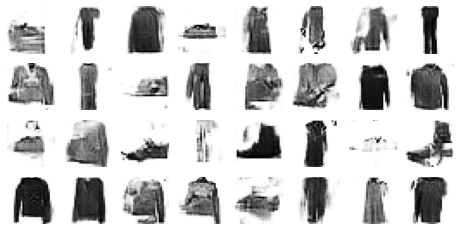

Epoch 3/50


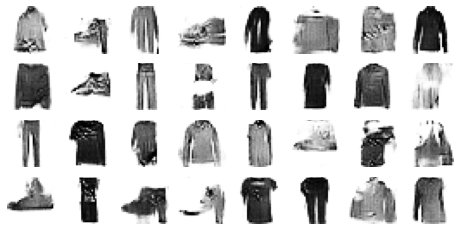

Epoch 4/50


KeyboardInterrupt: 

In [40]:
# GPUを使っていないため、途中で訓練を止めています
train_gan(gan, dataset, batch_size, codings_size)

Saving figure dcgan_generated_images_plot


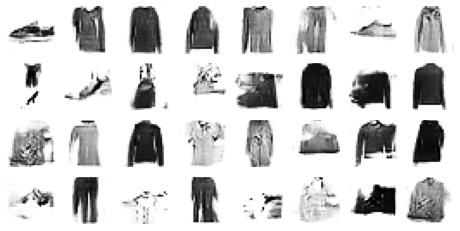

In [41]:
tf.random.set_seed(42)
np.random.seed(42)

noise = tf.random.normal(shape=[batch_size, codings_size])
generated_images = generator(noise)
plot_multiple_images(generated_images, 8)
save_fig("dcgan_generated_images_plot", tight_layout=False)

### DCGANの良さと課題

・良さ：視覚的概念のベクトル演算ができる（自然言語でいうword2vecのように）

例：(眼鏡をかけた男性)-(眼鏡をかけていない男性)+(眼鏡をかけていない女性)=(眼鏡をかけた女性)

→論文元を参照

・課題：大きな画像を作ろうとすると、全体としておかしな画像を生成してしまう

例：片方の袖が半袖で、もう片方が長袖のシャツ

# 17.9.3 PGGAN (Progressive Growing of GANs)

↓解説サイト

https://www.nogawanogawa.com/entry/pggan

↓Github（NVIDIAのTensorflowによる実装）

https://github.com/tkarras/progressive_growing_of_gans

<img src="img/PGGAN.png" alt="PGGAN">

・最初の時点では小さな画像を生成し、次第に生成器と判別器の両方に畳み込み層を加えていき、画像サイズを徐々に大きくする手法

(4×4、8×8、16×16、･･･、512×512、1024×1024)

・(a)から(c)に拡大するときに、新たな畳み込み層が追加されるが、(1-α)倍だけ元のtoRGBを残して学習を進める

・αを0から1に増やしていき、最終的に新しい畳み込み層のみに置き換わる

※(c)の出力(toRGB)では、32×32×3のカラー画像が生成される

### PGGANの良さと課題

良さ：高解像度の画像を生成できる

課題：画像の客観的な評価ができない　→　StyleGANで局所的な画像構造の類似度を計算

# 17.9.4 StyleGAN

↓解説サイト

https://qiita.com/ramu_206020/items/83a42c2a90a8d50bdad7

↓解説動画

https://www.youtube.com/watch?v=DttcP41XP1c&list=PLbtqZvaoOVPB2WCoUt9VCsl7BQHRdhb8m&index=6

↓Github

https://github.com/NVlabs/stylegan

<img src="img/StyleGAN.png" alt="StyleGAN">

FC：全結合層、w：重み、A：アフィン関数(全結合で活性化しない)、B：ノイズを生成

・潜在変数をstyle決定に利用することで、効率的に高解像度画像を生成する

・styleとは、正規化後の特徴量にかけるscaleとバイアスのことであり、以下の様に表せる

$$ \mathrm{AdaIN} = y_{i,s} \frac{x_i - \mathrm{mean}(x_i)}{\mathrm{std}(x_i)} + y_{i,b}$$

・AdaINとしてではなく、重みにsclaeをかけることで、ノイズをさらに除去した「StyleGAN2」もある

・人の顔の場合、低解像度では顔の輪郭など大枠を決め、高解像度では肌の色などを決める(Stlye Mixing)

↓Style Mixing
<img src="img/Style_mixing.jpg" alt="Style_mixing">

# BigGAN

・教科書には取り上げていないので今回は割愛するが、StyleGANと並んで高クオリティーな画像を生成する

・注意機構で「ある画素を生成する際に、どの画素の特徴量をどのくらいの重みで足せば良いかを計算する」

・すなわち局所的な形よりも広範囲の形を見ながら、画像全体で矛盾のない画像を生成できる

↓BigGANの基礎となるSAGANの解説サイト

https://blog.shikoan.com/sagan-paper/

↓注意機構の解説動画

https://www.youtube.com/watch?v=g5DSLeJozdw

↓Tensorflowのチュートリアル

https://www.tensorflow.org/hub/tutorials/biggan_generation_with_tf_hub?hl=ja

↓SAGAN
<img src="img/SAGAN.png" alt="SAGAN">

# その他のGAN

↓参考サイト

https://crystal-method.com/topics/gan/

### pix2pix

1枚の画像から学習したペアの画像関係を補完した画像を生成する

例：白黒画像からカラー画像へ変換

### Cycle GAN

2組の画像を使い、一方の画像から他方の画像を生成し、他方の画像から一方の画像に戻した時に（サイクルした時に）精度が高くなるように学習する。px2pixとの違いは元に戻すような変換も両方行える点にある。(白黒画像↔カラー画像)

### CGAN

生成器と識別機に画像データに加えて追加の情報を与えることで、条件付けができるように訓練を行う

例：0~9の数字を生成するように学習すると、「数字の3を生成」といったように生成させたい画像を指定できる

# Exercise Solutions

## 9.
ノイズ除去オートエンコーダを使ってイメージ分類器の事前学習をしよう。最も単純なところでMNISTを使っても、[CIFAR10](https://homl.info/122)のような複雑な画像データセットに挑戦してもよい。どのデータセットを使うかに関わらず、次の手順で作業をしなさい。 
* データセットを訓練セットとテストセットに分割し、訓練セット全体を対象として深層ノイズ除去オートエンコーダを訓練する
* 画像がよく再構築されていることをチェックする。コーディング層の各ニューロンをもっとも活性化されている画像を可視化する。
* オートエンコーダの下位層を再利用して、分類要のDNNを構築する。訓練セットのうちの500個の画像だけで訓練する。事前学習の有無により性能に差があるか？

In [42]:
[X_train, y_train], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [43]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation="relu"),
])

In [44]:
denoising_encoder.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNoi  (None, 32, 32, 3)        0         
 se)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten_5 (Flatten)         (None, 8192)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
N

In [45]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation="relu", input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2,
                                 padding="same", activation="sigmoid")
])

In [46]:
denoising_decoder.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 8192)              4202496   
                                                                 
 reshape_5 (Reshape)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_8 (Conv2DT  (None, 32, 32, 3)        867       
 ranspose)                                                       
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [47]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Nadam(),
                     metrics=["mse"])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_test, X_test))

Epoch 1/10
1563/1563 [==============================] - 259s 165ms/step - loss: 0.5931 - mse: 0.0185 - val_loss: 0.5987 - val_mse: 0.0194
Epoch 2/10
1563/1563 [==============================] - 251s 160ms/step - loss: 0.5724 - mse: 0.0099 - val_loss: 0.5758 - val_mse: 0.0107
Epoch 3/10
1563/1563 [==============================] - 251s 160ms/step - loss: 0.5674 - mse: 0.0079 - val_loss: 0.5720 - val_mse: 0.0092
Epoch 4/10
1563/1563 [==============================] - 258s 165ms/step - loss: 0.5651 - mse: 0.0070 - val_loss: 0.5710 - val_mse: 0.0089
Epoch 5/10
1563/1563 [==============================] - 243s 156ms/step - loss: 0.5639 - mse: 0.0066 - val_loss: 0.5683 - val_mse: 0.0077
Epoch 6/10
1563/1563 [==============================] - 241s 154ms/step - loss: 0.5631 - mse: 0.0063 - val_loss: 0.5667 - val_mse: 0.0072
Epoch 7/10
1563/1563 [==============================] - 6027s 4s/step - loss: 0.5625 - mse: 0.0061 - val_loss: 0.5659 - val_mse: 0.0068
Epoch 8/10
1563/1563 [==============

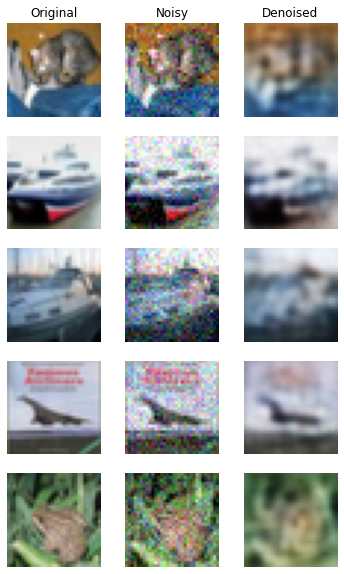

In [48]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()